# Multi-Modal AI 기초

Multi-Modal AI는 **텍스트, 이미지, 음성** 등 여러 형태의 데이터를 처리할 수 있는 AI입니다.

## Multi-Modal이란?

기존 LLM은 텍스트만 입출력했지만, Multi-Modal AI는 다양한 형태의 데이터를 다룹니다.

| 기능 | 입력 | 출력 | API/모델 |
|------|------|------|----------|
| 텍스트 생성 | 텍스트 | 텍스트 | GPT-4o |
| 이미지 분석 (Vision) | 이미지 + 텍스트 | 텍스트 | GPT-4o |
| 이미지 생성 | 텍스트 | 이미지 | DALL-E 3 |
| 음성 생성 (TTS) | 텍스트 | 음성 | TTS API |
| 음성 인식 (STT) | 음성 | 텍스트 | Whisper |

### 활용 사례

- **고객 서비스**: 음성으로 질문하고 음성으로 답변 받기
- **콘텐츠 생성**: 블로그 글에 맞는 이미지 자동 생성
- **접근성**: 시각 장애인을 위한 이미지 설명
- **교육**: 개념 설명과 함께 시각 자료 생성

In [1]:
import base64
from io import BytesIO
from pathlib import Path

from openai import OpenAI
from PIL import Image
from IPython.display import Audio, display

client = OpenAI()

---

## 1. 이미지 생성 (DALL-E 3)

텍스트 프롬프트로 이미지를 생성합니다.

### API 파라미터

| 파라미터 | 설명 | 옵션 |
|----------|------|------|
| `model` | 사용할 모델 | `dall-e-3`, `dall-e-2` |
| `prompt` | 이미지 설명 | 텍스트 |
| `size` | 이미지 크기 | `1024x1024`, `1792x1024`, `1024x1792` |
| `quality` | 품질 | `standard`, `hd` |
| `response_format` | 응답 형식 | `url`, `b64_json` |

> **비용 참고**: DALL-E 3 1024x1024 이미지 1장당 약 $0.04 (약 50원)

In [2]:
def generate_image(prompt: str, size: str = "1024x1024") -> Image.Image:
    """DALL-E 3로 이미지를 생성합니다."""
    response = client.images.generate(
        model="dall-e-3",
        prompt=prompt,
        size=size,
        n=1,
        response_format="b64_json"
    )
    
    # Base64 디코딩 → PIL Image
    image_base64 = response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

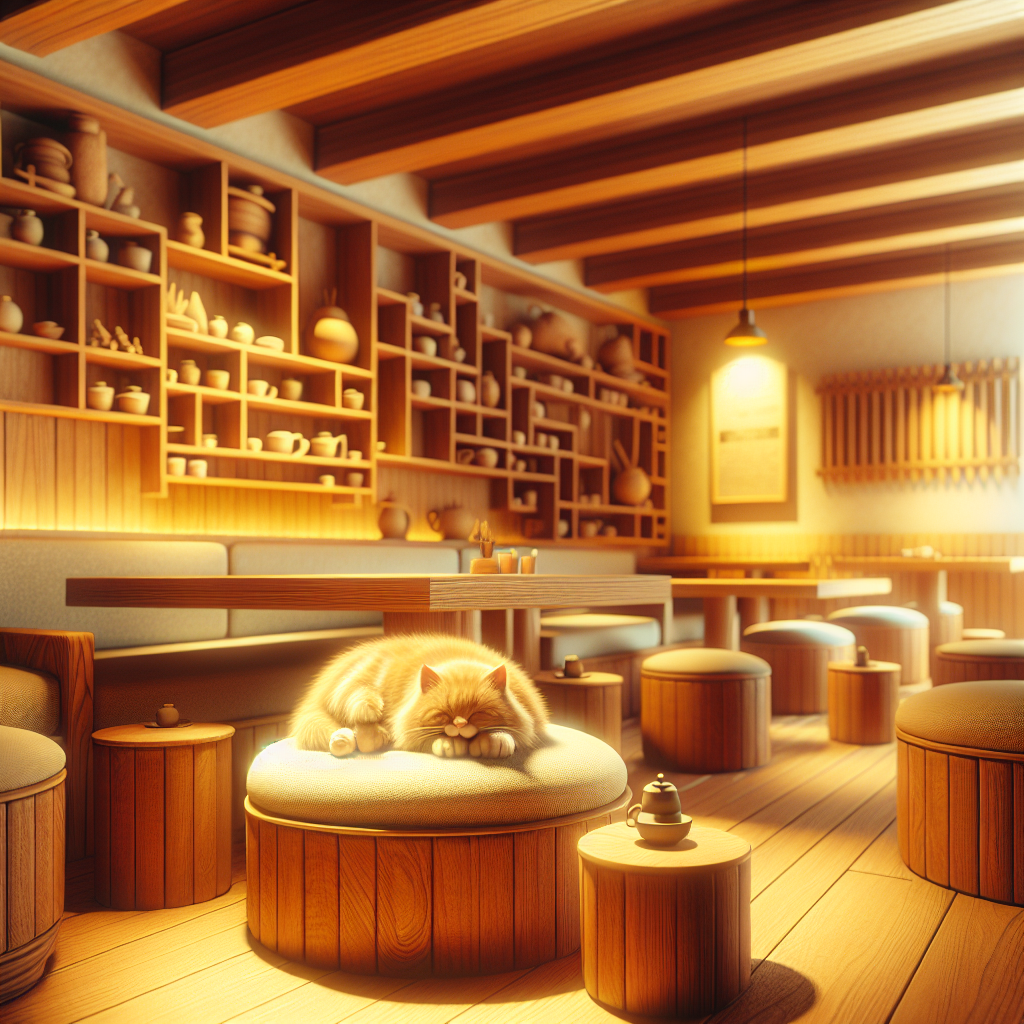

In [3]:
# 이미지 생성 테스트
image = generate_image(
    "A cozy coffee shop interior with warm lighting, "
    "wooden furniture, and a cat sleeping on a cushion, "
    "digital art style"
)
display(image)

---

## 2. 음성 생성 (Text-to-Speech)

텍스트를 자연스러운 음성으로 변환합니다.

### API 파라미터

| 파라미터 | 설명 | 옵션 |
|----------|------|------|
| `model` | TTS 모델 | `tts-1`, `tts-1-hd`, `gpt-4o-mini-tts` |
| `voice` | 음성 스타일 | `alloy`, `echo`, `fable`, `onyx`, `nova`, `shimmer` |
| `input` | 변환할 텍스트 | 최대 4096자 |

### 음성 스타일 특징

| Voice | 특징 |
|-------|------|
| `alloy` | 중성적, 균형 잡힌 톤 |
| `echo` | 따뜻하고 부드러운 남성 음성 |
| `fable` | 표현력 있는 영국식 억양 |
| `onyx` | 깊고 권위 있는 남성 음성 |
| `nova` | 친근하고 에너지 넘치는 여성 음성 |
| `shimmer` | 명확하고 전문적인 여성 음성 |

In [ ]:
def text_to_speech(text: str, voice: str = "nova") -> bytes:
    """텍스트를 음성으로 변환합니다."""
    response = client.audio.speech.create(
        model="tts-1",
        voice=voice,
        input=text
    )
    return response.content

In [ ]:
# TTS 테스트
audio_data = text_to_speech(
    "안녕하세요! Multi-Modal AI의 세계에 오신 것을 환영합니다. "
    "이제 AI가 텍스트뿐만 아니라 이미지와 음성도 다룰 수 있습니다."
)

# 노트북에서 오디오 재생
Audio(audio_data, autoplay=True)

In [ ]:
# 다양한 음성 비교
sample_text = "Hello! This is a test of different voice styles."

for voice in ["alloy", "nova", "onyx"]:
    print(f"Voice: {voice}")
    audio = text_to_speech(sample_text, voice=voice)
    display(Audio(audio, autoplay=False))

---

## 3. 이미지 분석 (Vision)

GPT-4o는 이미지를 입력받아 분석할 수 있습니다.

### 이미지 전달 방식

1. **URL**: 웹에 공개된 이미지 URL 전달
2. **Base64**: 로컬 이미지를 Base64로 인코딩하여 전달

### 메시지 구조

```python
{
    "role": "user",
    "content": [
        {"type": "text", "text": "이 이미지를 설명해주세요"},
        {"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,..."}}
    ]
}
```

In [ ]:
def encode_image_to_base64(image_path: str) -> str:
    """이미지 파일을 Base64로 인코딩합니다."""
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

def analyze_image(image_source: str, prompt: str = "이 이미지를 자세히 설명해주세요.") -> str:
    """이미지를 분석합니다. URL 또는 파일 경로를 받습니다."""
    
    # URL인지 파일 경로인지 판단
    if image_source.startswith(("http://", "https://")):
        image_url = image_source
    else:
        # 로컬 파일 → Base64
        base64_image = encode_image_to_base64(image_source)
        # 확장자에 따른 MIME 타입 결정
        ext = Path(image_source).suffix.lower()
        mime_type = {"jpg": "jpeg", "jpeg": "jpeg", "png": "png", "gif": "gif", "webp": "webp"}.get(ext.strip("."), "jpeg")
        image_url = f"data:image/{mime_type};base64,{base64_image}"
    
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": image_url}}
                ]
            }
        ],
        max_tokens=1000
    )
    
    return response.choices[0].message.content

In [ ]:
# URL 이미지 분석 테스트
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg"

description = analyze_image(image_url, "이 이미지에 무엇이 있나요? 한국어로 답해주세요.")
print(description)

In [ ]:
def analyze_pil_image(image: Image.Image, prompt: str = "이 이미지를 설명해주세요.") -> str:
    """PIL Image 객체를 분석합니다."""
    # PIL Image → Base64
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    base64_image = base64.b64encode(buffer.getvalue()).decode("utf-8")
    
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_image}"}}
                ]
            }
        ],
        max_tokens=1000
    )
    
    return response.choices[0].message.content

In [ ]:
# 위에서 생성한 이미지를 다시 분석해보기
# (이미지 생성 셀을 먼저 실행해야 합니다)
if 'image' in dir():
    analysis = analyze_pil_image(image, "이 이미지의 분위기와 주요 요소를 설명해주세요.")
    print(analysis)
else:
    print("먼저 이미지 생성 셀을 실행해주세요.")

---

## 4. 음성 인식 (Speech-to-Text)

Whisper 모델로 음성을 텍스트로 변환합니다.

### API 파라미터

| 파라미터 | 설명 |
|----------|------|
| `model` | `whisper-1` |
| `file` | 오디오 파일 (mp3, wav, m4a 등) |
| `language` | 언어 코드 (선택, 예: `ko`, `en`) |

In [ ]:
def speech_to_text(audio_path: str, language: str = None) -> str:
    """음성 파일을 텍스트로 변환합니다."""
    with open(audio_path, "rb") as audio_file:
        kwargs = {"model": "whisper-1", "file": audio_file}
        if language:
            kwargs["language"] = language
        
        response = client.audio.transcriptions.create(**kwargs)
    
    return response.text

In [ ]:
# TTS로 생성한 음성을 파일로 저장 후 다시 STT로 변환하는 테스트
test_text = "인공지능 기술이 빠르게 발전하고 있습니다."

# TTS로 음성 생성
audio_bytes = text_to_speech(test_text)

# 파일로 저장
audio_path = "test_audio.mp3"
with open(audio_path, "wb") as f:
    f.write(audio_bytes)

print(f"원본 텍스트: {test_text}")

# STT로 다시 변환
transcribed = speech_to_text(audio_path, language="ko")
print(f"변환된 텍스트: {transcribed}")

---

## 5. 통합 예제: 여행 가이드 어시스턴트

지금까지 배운 기능들을 조합하여 여행 가이드 어시스턴트를 만들어봅니다.

- 여행지 추천 → 텍스트 생성
- 여행지 이미지 → 이미지 생성
- 설명 음성 → TTS

In [ ]:
def travel_guide(destination: str):
    """여행지에 대한 설명, 이미지, 음성을 생성합니다."""
    
    print(f"🌍 {destination} 여행 가이드 생성 중...\n")
    
    # 1. 텍스트 설명 생성
    print("📝 여행 정보 생성 중...")
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": "당신은 전문 여행 가이드입니다. 여행지에 대해 간결하고 유용한 정보를 제공합니다."
            },
            {
                "role": "user",
                "content": f"{destination}에 대해 3-4문장으로 소개해주세요. 추천 명소 1곳과 추천 음식 1개를 포함해주세요."
            }
        ]
    )
    description = response.choices[0].message.content
    print(f"\n{description}\n")
    
    # 2. 이미지 생성
    print("🎨 이미지 생성 중...")
    image = generate_image(
        f"A beautiful travel photograph of {destination}, "
        f"showing famous landmarks and local atmosphere, "
        f"vibrant colors, professional photography style"
    )
    display(image)
    
    # 3. 음성 생성
    print("\n🔊 음성 가이드 생성 중...")
    audio = text_to_speech(description, voice="nova")
    display(Audio(audio, autoplay=True))
    
    return description, image, audio

In [ ]:
# 여행 가이드 실행
description, image, audio = travel_guide("교토")

---

## 6. Gradio UI로 만들기

Gradio를 사용하여 인터랙티브한 Multi-Modal 앱을 만듭니다.

In [ ]:
import gradio as gr

In [ ]:
def travel_guide_ui(destination: str):
    """Gradio UI용 여행 가이드 함수"""
    if not destination.strip():
        return "여행지를 입력해주세요.", None, None
    
    # 텍스트 설명
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "당신은 전문 여행 가이드입니다."},
            {"role": "user", "content": f"{destination}에 대해 3-4문장으로 소개해주세요."}
        ]
    )
    description = response.choices[0].message.content
    
    # 이미지 생성
    image = generate_image(
        f"Beautiful travel photo of {destination}, landmarks, vibrant colors"
    )
    
    # 음성 생성
    audio = text_to_speech(description, voice="nova")
    
    return description, image, audio

# Gradio 앱 생성
with gr.Blocks(title="여행 가이드 AI") as demo:
    gr.Markdown("# 🌍 AI 여행 가이드")
    gr.Markdown("여행지를 입력하면 설명, 이미지, 음성 가이드를 생성합니다.")
    
    with gr.Row():
        destination_input = gr.Textbox(
            label="여행지 입력",
            placeholder="예: 파리, 도쿄, 제주도..."
        )
        generate_btn = gr.Button("가이드 생성", variant="primary")
    
    with gr.Row():
        with gr.Column():
            description_output = gr.Textbox(label="여행지 소개", lines=5)
            audio_output = gr.Audio(label="음성 가이드", autoplay=True)
        image_output = gr.Image(label="여행지 이미지")
    
    generate_btn.click(
        fn=travel_guide_ui,
        inputs=destination_input,
        outputs=[description_output, image_output, audio_output]
    )

demo.launch()

---

## 요약

이번 노트북에서는 Multi-Modal AI의 기초를 알아보았습니다.

### 핵심 기능

| 기능 | API | 주요 사용처 |
|------|-----|------------|
| 이미지 생성 | `client.images.generate()` | 콘텐츠 생성, 시각화 |
| 음성 생성 | `client.audio.speech.create()` | 접근성, 오디오 콘텐츠 |
| 이미지 분석 | `client.chat.completions.create()` | 이미지 이해, OCR |
| 음성 인식 | `client.audio.transcriptions.create()` | 음성 입력, 회의록 |

### 비용 고려사항

- DALL-E 3: 이미지당 약 $0.04
- TTS: 1M 문자당 약 $15
- Whisper: 분당 약 $0.006
- Vision: 이미지 크기에 따라 토큰 비용 발생

### 다음 단계

- Tool Use와 결합하여 더 똑똑한 어시스턴트 만들기
- 실시간 스트리밍 음성 대화
- 비디오 분석 (GPT-4o with video)